# Predicting LendingClub Loan Charge-offs from Loan Origination Data


## Contents

* [1. Introduction](#1)
 * [1.1 References](#1.1)
* [2. Import the Data](#2)
* [3. Response Variable](#3)
* [4. Limit the Feature Space](#4)
 * [4.1 Drop features missing more than 30% data](#4.1)
 * [4.2 Only keep loan features known to potential investors](#4.2)
* [5. Pre-processing and Exploratory Analysis](#5)
* [6. More Pre-processing](#6)
 * [6.1 Convert loan status to 0/1 charge-off indicator](#6.1)
 * [6.2 Create dummy variables](#6.2)
 * [6.3 Train/test split](#6.3)
* [7. Linear Dependence of Charge-off on the Predictors](#7)
* [8. Model Training and Testing](#8)
 * [8.1 Logistic regression with SGD training](#8.1)
 * [8.2 Random forest classifier](#8.2)
 * [8.3 k-nearest neighbors](#8.3)
 * [8.4 Tune hyperparameters on the chosen model more finely](#8.4)
 * [8.5 Test set evaluation](#8.5)
* [9. Conclusion](#9)

# 1. Introduction
<a id="1"></a>

[LendingClub](https://www.lendingclub.com/) is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Lending_Club),

> Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a machine learning model to predict the probability that a loan will charge off. We will attempt to only use data available to investors via the LendingClub loan listing, including information about the borrower (income, employment length, FICO score, debt-to-income ratio, etc.) and the loan listing (the loan amount, loan purpose, loan grade, interest rate, installment, etc.). Such a predictive model could help LendingClub investors make better-informed investment decisions. We will only consider loans that LendingClub accepted under its credit underwriting policy.

## 1.1 References
<a id="1.1"></a>

* LendingClub information
 * [LendingClub website](https://www.lendingclub.com/)
 * [LendingClub Wikipedia page](https://en.wikipedia.org/wiki/Lending_Club)
* Datasets
 * [LendingClub statistics](https://www.lendingclub.com/info/download-data.action) - Original data source, aggregated on Kaggle
 * [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle
 * [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another LendingClub dataset on Kaggle, not used in this project
* This project
 * [Kaggle notebook](https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data)
 * [GitHub repo](https://github.com/jgcorliss/lending-club)

# 2. Import the Data
<a id="2"></a>

In [103]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')
#Get rid of warnings
import warnings
warnings.filterwarnings('ignore')
import os

Read the data into a pandas dataframe:

In [5]:
os.getcwd()

'C:\\Users\\Sameer\\Downloads\\lending-club-master\\lending-club-master'

In [6]:
loans = pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)

Check basic dataframe info:

In [7]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


There are 2.2 million rows and 150 variables. The size of the dataset is 1.8 GB.

Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [8]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1881976,3064897,NaN,18000.0,18000.0,18000.0,36 months,13.11,607.45,B,B4,United Technologies,5 years,RENT,84500.0,Not Verified,Jan-2013,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=3064897,Borrower added on 01/09/13 > Still has high interest balances and would like to reduce my rate with this loan.<br>,debt_consolidation,2013 Consolidation,061xx,CT,27.64,0.0,Jun-2000,660.0,664.0,0.0,67.0,NaN,13.0,0.0,22826.0,83.9,25.0,f,0.00,0.00,10773.150000,10773.15,2527.43,1896.46,0.00,6349.26,1079.3742,Dec-2013,609.60,NaN,Feb-2019,559.0,555.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,102830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27200.0,NaN,NaN,NaN,4.0,7910.0,198.0,99.1,0.0,0.0,137.0,153.0,14.0,10.0,0.0,14.0,67.0,14.0,67.0,0.0,6.0,7.0,6.0,12.0,10.0,8.0,15.0,7.0,13.0,0.0,0.0,0.0,1.0,91.0,100.0,0.0,0.0,111133.0,102830.0,22700.0,83933.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,Y,Apr-2014,COMPLETE,Mar-2014,6348.0,40.43,0.0
723924,76764992,NaN,7500.0,7500.0,7500.0,36 months,23.13,290.84,F,F1,caregiver,4 years,MORTGAGE,25000.0,Source Verified,Apr-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=76764992,NaN,debt_consolidation,Debt consolidation,959xx,CA,15.51,0.0,May-2005,665.0,669.0,1.0,NaN,51.0,9.0,1.0,6959.0,61.0,13.0,f,0.00,0.00,9713.639433,9713.64,7500.00,2213.64,0.00,0.00,0.0000,Dec-2017,4264.79,NaN,Dec-2017,684.0,680.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,137987.0,1.0,0.0,0.0,0.0,122.0,0.0,NaN,3.0,6.0,1039.0,61.0,11400.0,0.0,0

# 3. Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` variable. What are the value counts for this variable?

In [9]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [10]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [11]:
loans.shape

(1345310, 151)

There are 1,345,310 loans remaining. Check that the statuses are as expected:

In [12]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

Status counts as percentages:

In [13]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64

About 80% of the remaining loans have been fully paid and 20% have charged off, so we have a somewhat unbalanced classification problem.

# 4. Limit the Feature Space
<a id="4"></a>

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

Definitions of the features are given in the LendingClub Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## 4.1 Drop features missing more than 30% data
<a id="4.1"></a>

First calculate the percentage of missing data for each feature:

In [14]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Top 10 features missing the most data:

In [15]:
missing_fractions.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.997206
hardship_start_date                           0.995723
hardship_end_date                             0.995723
payment_plan_start_date                       0.995723
hardship_length                               0.995723
hardship_dpd                                  0.995723
hardship_loan_status                          0.995723
hardship_last_payment_amount                  0.995723
dtype: float64

Let's visualize the distribution of missing data percentages:

Text(0, 0.5, 'Feature count')

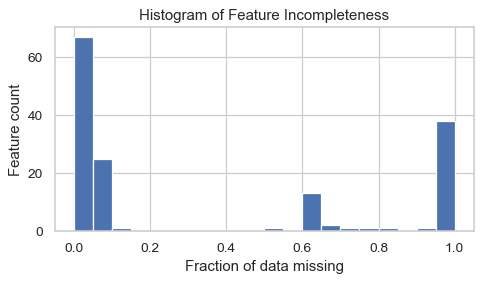

In [16]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [17]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [18]:
len(drop_list)

58

Drop these features:

In [19]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [20]:
loans.shape

(1345310, 93)

## 4.2 Only keep loan features known to potential investors
<a id="4.2"></a>

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [21]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [22]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [23]:
len(keep_list)

31

The list of features to drop is any feature not in `keep_list`:

In [24]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [25]:
len(drop_list)

62

Drop these features:

In [26]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [27]:
loans.shape

(1345310, 31)

# 5. Pre-processing and Exploratory Analysis
<a id="5"></a>

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [28]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

Print the remaining features for future reference:

In [29]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


## 5.1 id

Data Dictionary: "A unique [LendingClub] assigned ID for the loan listing."

In [30]:
loans['id'].sample(5)

1410531    143736930
711715      78328764
1836049      5794674
1601555    131297037
142792      60286592
Name: id, dtype: object

Are all the IDs unique?

In [31]:
loans['id'].describe()

count      1345310
unique     1345310
top       75358995
freq             1
Name: id, dtype: object

Yes, they are all unique. The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [32]:
loans.drop('id', axis=1, inplace=True)

## 5.2 loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [36]:
loans['loan_amnt'].describe()

count   1345310.00000
mean      14419.97201
std        8717.05079
min         500.00000
25%        8000.00000
50%       12000.00000
75%       20000.00000
max       40000.00000
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$12,000.

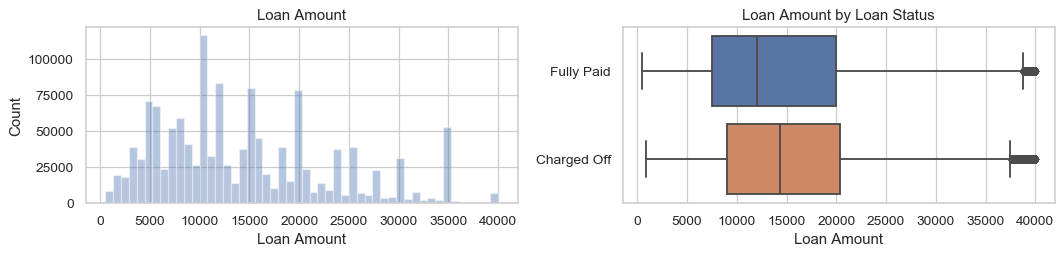

In [37]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [38]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.00000,15565.05544,8814.56008,900.00000,9000.00000,14350.00000,20400.00000,40000.00000
Fully Paid,1076751.00000,14134.36981,8669.02897,500.00000,7500.00000,12000.00000,20000.00000,40000.00000


## 5.3 term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [39]:
loans['term'].value_counts(dropna=False)

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

Convert `term` to integers.

In [40]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [41]:
loans['term'].value_counts(normalize=True)

36   0.75874
60   0.24126
Name: term, dtype: float64

Compare the charge-off rate by loan period:

In [42]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36   0.15993
60   0.32445
Name: loan_status, dtype: float64

About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

## 5.4 int_rate

Data Dictionary: "Interest Rate on the loan."

In [43]:
loans['int_rate'].describe()

count   1345310.00000
mean         13.23962
std           4.76872
min           5.31000
25%           9.75000
50%          12.74000
75%          15.99000
max          30.99000
Name: int_rate, dtype: float64

Interest rates range from 5.31% to 30.99% (!) with a median of 12.74%.

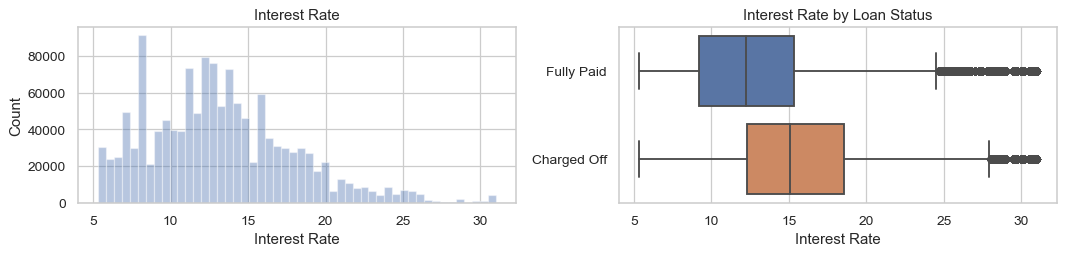

In [44]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [45]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.00000,15.71071,4.91039,5.31000,12.29000,15.05000,18.55000,30.99000
Fully Paid,1076751.00000,12.62329,4.52723,5.31000,9.17000,12.23000,15.31000,30.99000


## 5.5 installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [46]:
loans['installment'].describe()

count   1345310.00000
mean        438.07553
std         261.51260
min           4.93000
25%         248.48000
50%         375.43000
75%         580.73000
max        1719.83000
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,719, with a median of \$375.

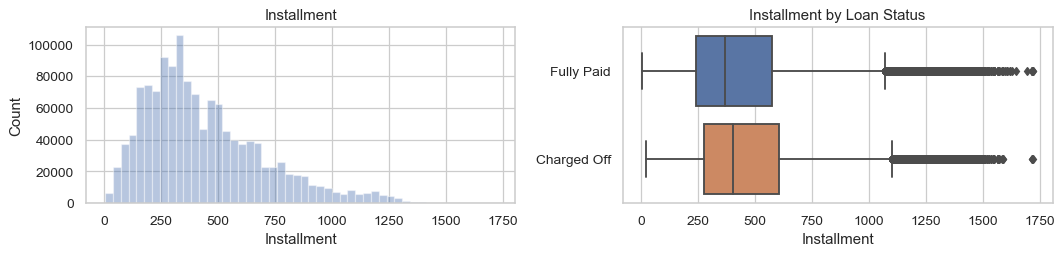

In [47]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [48]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.00000,465.14799,262.77411,21.62000,275.29000,402.83000,605.31000,1717.63000
Fully Paid,1076751.00000,431.32323,260.75956,4.93000,240.92000,368.26000,573.06000,1719.83000


Loans that charge off have \$30 higher installments on average.

## 5.6 grade, sub_grade

Data Dictionary for `grade`: "LendingClub assigned loan grade."

Data Dictionary for `sub_grade`: "LendingClub assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [49]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [50]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [51]:
loans.drop('grade', axis=1, inplace=True)

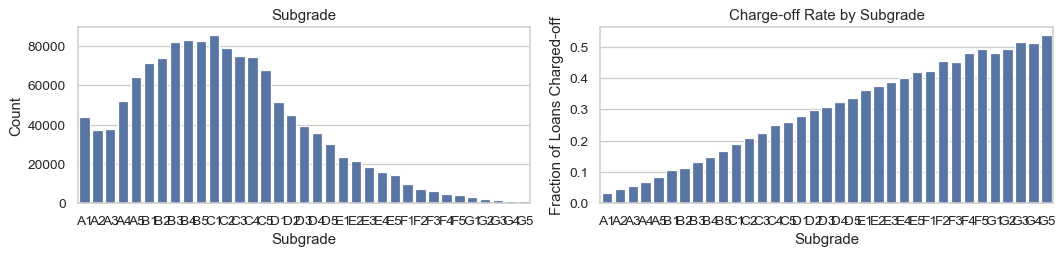

In [52]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

## 5.7 emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [53]:
loans['emp_title'].describe()

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [54]:
loans.drop(labels='emp_title', axis=1, inplace=True)

## 5.8 emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [55]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        88494
10+ years    442199
2 years      121743
3 years      107597
4 years       80556
5 years       84154
6 years       62733
7 years       59624
8 years       60701
9 years       50937
< 1 year     108061
NaN           78511
Name: emp_length, dtype: int64

Note there are 78,511 loans without data on the length of employment.

Convert `emp_length` to integers:

In [56]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [57]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [58]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [59]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [60]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.00000     108061
1.00000      88494
2.00000     121743
3.00000     107597
4.00000      80556
5.00000      84154
6.00000      62733
7.00000      59624
8.00000      60701
9.00000      50937
10.00000    442199
nan          78511
Name: emp_length, dtype: int64

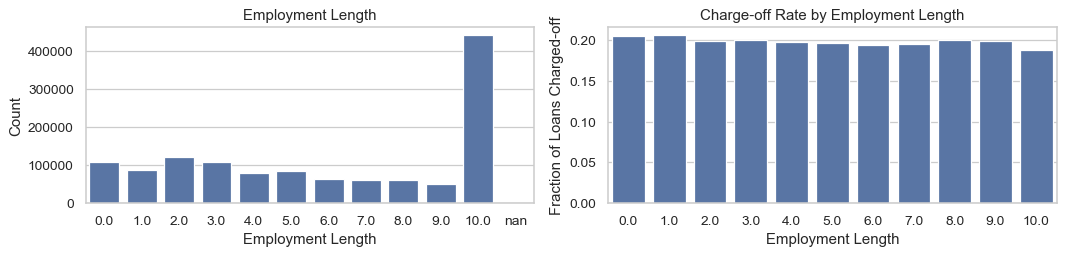

In [61]:
plot_var('emp_length', 'Employment Length', continuous=False)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

## 5.9 home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [62]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [63]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [64]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

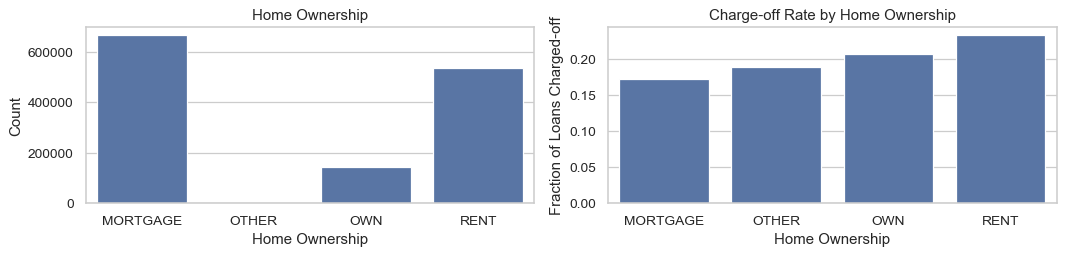

In [65]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [66]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE   0.17208
OTHER      0.18828
OWN        0.20620
RENT       0.23217
Name: loan_status, dtype: float64

## 5.10 annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [67]:
loans['annual_inc'].describe()

count    1345310.00000
mean       76247.63641
std        69925.09843
min            0.00000
25%        45780.00000
50%        65000.00000
75%        90000.00000
max     10999200.00000
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$10,999,200, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [68]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [69]:
loans.drop('annual_inc', axis=1, inplace=True)

In [70]:
loans['log_annual_inc'].describe()

count   1345310.00000
mean          4.81281
std           0.24772
min           0.00000
25%           4.66069
50%           4.81292
75%           4.95425
max           7.04136
Name: log_annual_inc, dtype: float64

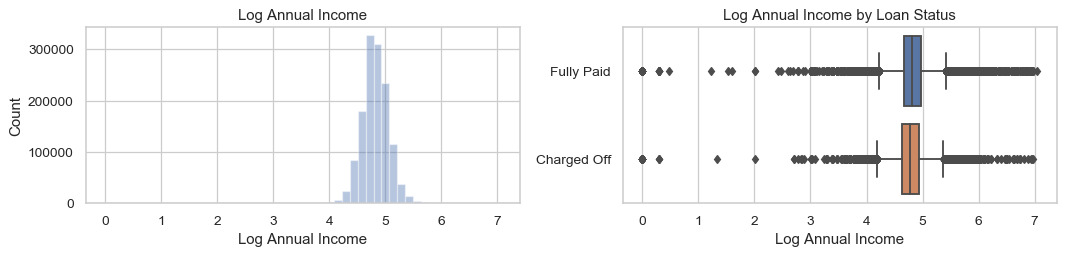

In [71]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [72]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.00000,4.78176,0.24198,0.00000,4.63348,4.77816,4.92942,6.97772
Fully Paid,1076751.00000,4.82056,0.24853,0.00000,4.67211,4.81292,4.96849,7.04136


## 5.11 verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

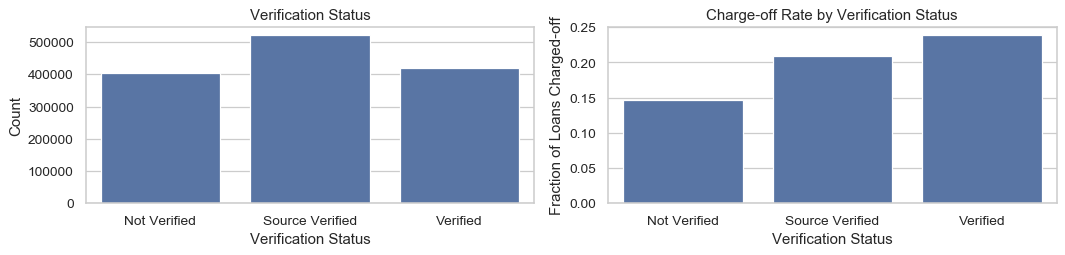

In [73]:
plot_var('verification_status', 'Verification Status', continuous=False)

## 5.12 issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

## 5.13 purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [74]:
loans['purpose'].value_counts()

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [75]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding              0.12162
car                  0.14679
credit_card          0.16927
educational          0.17178
home_improvement     0.17716
major_purchase       0.18600
vacation             0.19173
other                0.21040
debt_consolidation   0.21147
medical              0.21776
house                0.21881
moving               0.23354
renewable_energy     0.23687
small_business       0.29709
Name: loan_status, dtype: float64

Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.

## 5.14 title

Data Dictionary: "The loan title provided by the borrower."

In [76]:
loans['title'].describe()

count                1328651
unique                 61682
top       Debt consolidation
freq                  660960
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [77]:
loans['title'].value_counts().head(10)

Debt consolidation         660960
Credit card refinancing    249910
Home improvement            75073
Other                       66778
Major purchase              24045
Debt Consolidation          15695
Medical expenses            13576
Business                    11750
Car financing               11220
Vacation                     8046
Name: title, dtype: int64

There are 61,682 different titles in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [78]:
loans.drop('title', axis=1, inplace=True)

## 5.15 zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [79]:
loans['zip_code'].sample(5)

292231     125xx
1319869    551xx
1232882    490xx
2220693    086xx
1079160    775xx
Name: zip_code, dtype: object

In [80]:
loans['zip_code'].nunique()

943

In [81]:
loans['addr_state'].sample(5)

204522     PA
2027529    NY
2183045    OH
1156673    CO
1331642    CA
Name: addr_state, dtype: object

In [82]:
loans['addr_state'].nunique()

51

There are a lot of different zip codes, so let's just keep the state column.

In [83]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [84]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC   0.13209
ME   0.13842
VT   0.13952
IA   0.14286
OR   0.14385
NH   0.14576
WV   0.15519
CO   0.15527
WA   0.15756
SC   0.16277
KS   0.16744
WY   0.16769
MT   0.16872
UT   0.17059
CT   0.17376
RI   0.17867
IL   0.18097
WI   0.18351
GA   0.18393
ID   0.18828
MA   0.19053
CA   0.19610
AZ   0.19630
AK   0.19655
MN   0.19743
DE   0.19746
TX   0.19822
VA   0.19942
HI   0.20201
MI   0.20296
ND   0.20474
OH   0.20528
NC   0.20784
PA   0.20792
KY   0.20983
NJ   0.21121
MO   0.21294
MD   0.21308
SD   0.21323
NM   0.21366
TN   0.21408
IN   0.21408
FL   0.21475
NV   0.21922
NY   0.22043
LA   0.23182
OK   0.23475
AL   0.23632
AR   0.24087
NE   0.25181
MS   0.26078
Name: loan_status, dtype: float64

The charge-off rate ranges from 13.0% in Washington, DC to 26% in Mississippi.

## 5.16 dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [85]:
loans['dti'].describe()

count   1344936.00000
mean         18.28267
std          11.16045
min          -1.00000
25%          11.79000
50%          17.61000
75%          24.06000
max         999.00000
Name: dti, dtype: float64

Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

Text(0.5, 1.0, 'Debt-to-income Ratio')

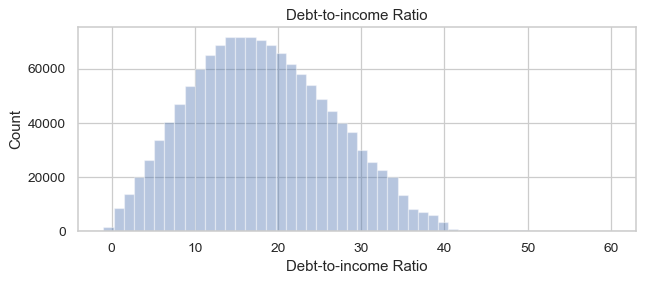

In [86]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

How many of the `dti` values are "outliers" (above 60)?

In [87]:
(loans['dti']>=60).sum()

1715

Very few. Compare the summary statistics by loan status:

In [88]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268488.00000,20.17120,11.83175,0.00000,13.55000,19.76000,26.31000,999.00000
Fully Paid,1076448.00000,17.81163,10.93593,-1.00000,11.43000,17.11000,23.44000,999.00000


Completed loans that are charged off tend to have higher debt-to-income ratios.

## 5.17 earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [89]:
loans['earliest_cr_line'].sample(5)

926118     Jun-1998
1256465    Jun-1990
253368     Mar-1999
736333     May-1996
2193304    Aug-2002
Name: earliest_cr_line, dtype: object

In [90]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [91]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [92]:
loans['earliest_cr_line'].describe()

count   1345310.00000
mean       1998.69256
std           7.60826
min        1934.00000
25%        1995.00000
50%        2000.00000
75%        2004.00000
max        2015.00000
Name: earliest_cr_line, dtype: float64

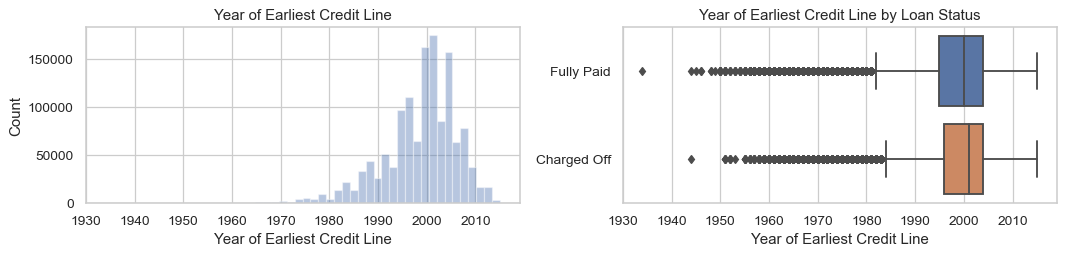

In [93]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

## 5.18 fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [94]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1345310.00000,1345310.00000
mean,696.18504,700.18518
std,31.85251,31.85316
min,625.00000,629.00000
25%,670.00000,674.00000
50%,690.00000,694.00000
75%,710.00000,714.00000
max,845.00000,850.00000


Check the Pearson correlation between these values:

In [95]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.00000,1.00000
fico_range_high,1.00000,1.00000


We only need to keep one of the FICO scores. We'll take the average of the two and call it `fico_score`:

In [96]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [97]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

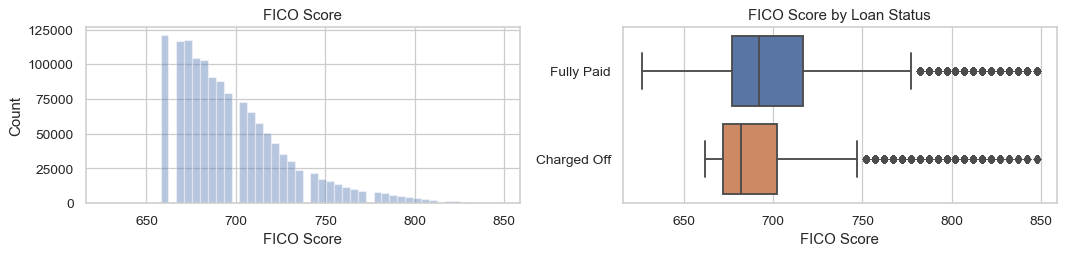

In [98]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans. Compare the summary statistics:

In [99]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.00000,689.85014,25.94874,662.00000,672.00000,682.00000,702.00000,847.50000
Fully Paid,1076751.00000,700.26398,32.83401,627.00000,677.00000,692.00000,717.00000,847.50000


Loans that charge off have a FICO score 10 points lower on average.

## 5.19 open_acc

Data Dictionary: "The number of open credit lines in the borrower's credit file."

Text(0.5, 1.0, 'Number of Open Credit Lines')

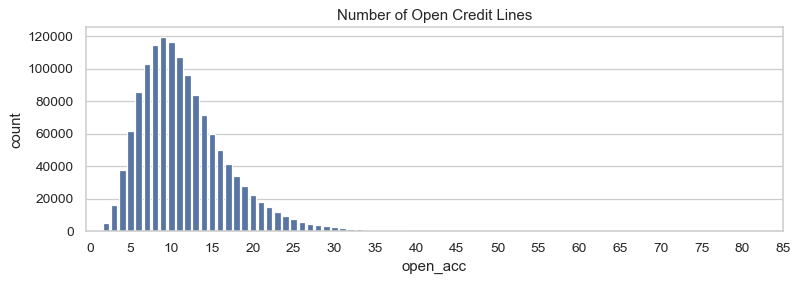

In [100]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans['open_acc'], order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [101]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.00000,11.90127,5.63796,0.00000,8.00000,11.00000,15.00000,76.00000
Fully Paid,1076751.00000,11.51676,5.42935,0.00000,8.00000,11.00000,14.00000,90.00000


There's does not appear to be a significant difference.

## 5.20 pub_rec

Data Dictionary: "Number of derogatory public records."

In [102]:
loans['pub_rec'].value_counts().sort_index()

0.00000     1117425
1.00000      190789
2.00000       24435
3.00000        7399
4.00000        2630
5.00000        1266
6.00000         636
7.00000         283
8.00000         160
9.00000          83
10.00000         57
11.00000         40
12.00000         27
13.00000         18
14.00000          5
15.00000          9
16.00000          5
17.00000          3
18.00000          6
19.00000          5
20.00000          3
21.00000          6
22.00000          2
23.00000          1
24.00000          2
25.00000          1
28.00000          3
34.00000          1
37.00000          1
40.00000          1
46.00000          1
47.00000          1
49.00000          2
54.00000          1
61.00000          1
63.00000          1
86.00000          1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [104]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,0.247,0.657,0.000,0.000,0.000,0.000,86.000
Fully Paid,1076751.000,0.207,0.587,0.000,0.000,0.000,0.000,63.000


## 5.21 revol_bal

Data Dictionary: "Total credit revolving balance."

In [105]:
loans['revol_bal'].describe()

count   1345310.000
mean      16248.115
std       22328.169
min           0.000
25%        5943.000
50%       11134.000
75%       19755.750
max     2904836.000
Name: revol_bal, dtype: float64

Do a log transform:

In [106]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [107]:
loans.drop('revol_bal', axis=1, inplace=True)

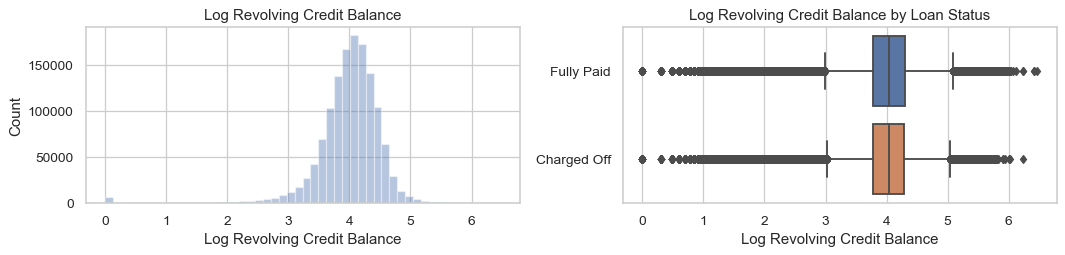

In [108]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [109]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,3.986,0.515,0.000,3.777,4.044,4.281,6.242
Fully Paid,1076751.000,3.994,0.536,0.000,3.773,4.047,4.299,6.463


There isn't a large difference in the means.

## 5.22 revol_util

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [110]:
loans['revol_util'].describe()

count   1344453.000
mean         51.810
std          24.521
min           0.000
25%          33.400
50%          52.200
75%          70.700
max         892.300
Name: revol_util, dtype: float64

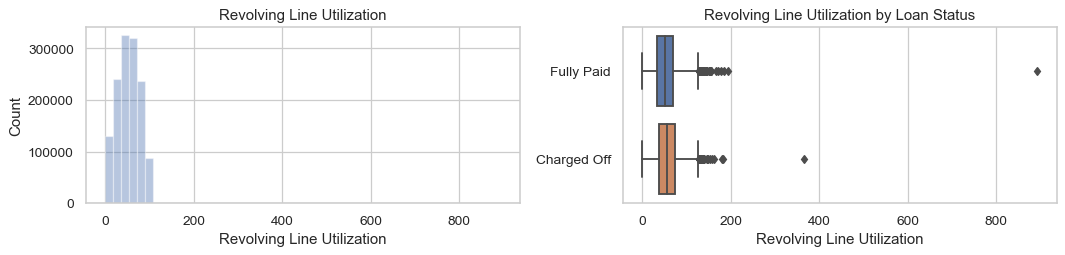

In [111]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [112]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268379.000,54.758,23.866,0.000,37.400,55.500,73.100,366.600
Fully Paid,1076074.000,51.075,24.627,0.000,32.500,51.300,70.100,892.300


## 5.23 total_acc

Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

Text(0.5, 1.0, 'Total Number of Credit Lines')

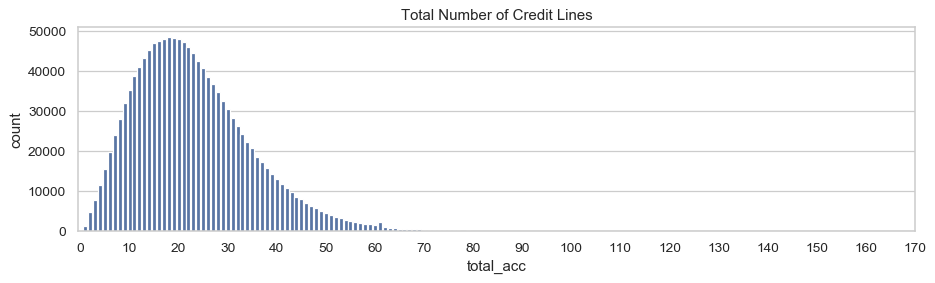

In [113]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [114]:
loans.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,24.709,12.117,2.000,16.000,23.000,31.000,176.000
Fully Paid,1076751.000,25.049,11.968,2.000,16.000,23.000,32.000,162.000


No large differences here.

## 5.24 initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

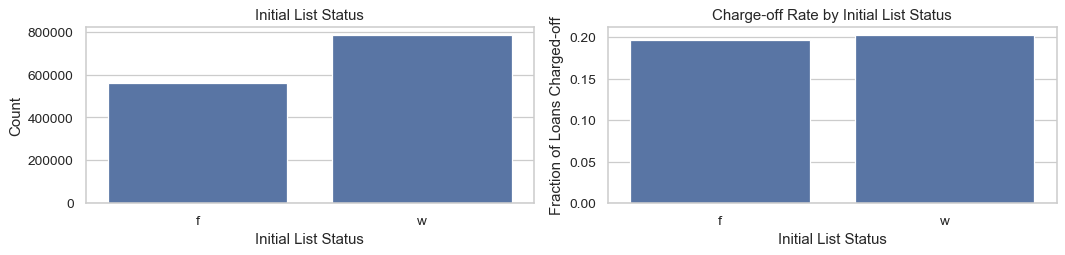

In [115]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

## 5.25 application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [116]:
loans['application_type'].value_counts()

Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [117]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual   0.199
Joint App    0.246
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

## 5.26 mort_acc

Data Dictionary: "Number of mortgage accounts."

In [118]:
loans['mort_acc'].describe()

count   1298029.000
mean          1.671
std           2.000
min           0.000
25%           0.000
50%           1.000
75%           3.000
max          51.000
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do. Check the top 10 values:

In [119]:
loans['mort_acc'].value_counts().head(10)

0.000    523837
1.000    226135
2.000    188941
3.000    139381
4.000     94920
5.000     57632
6.000     32539
7.000     16850
8.000      8378
9.000      4285
Name: mort_acc, dtype: int64

Compare the summary statistics by loan status:

In [120]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261673.000,1.371,1.826,0.000,0.000,1.000,2.000,29.000
Fully Paid,1036356.000,1.746,2.035,0.000,0.000,1.000,3.000,51.000


Individuals who pay off their loans are more likely to have several mortgage accounts.

## 5.27 pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [121]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.000     1176953
1.000      157696
2.000        7769
3.000        1583
4.000         396
5.000         141
6.000          46
7.000          15
8.000           9
9.000           3
11.000          1
12.000          1
Name: pub_rec_bankruptcies, dtype: int64

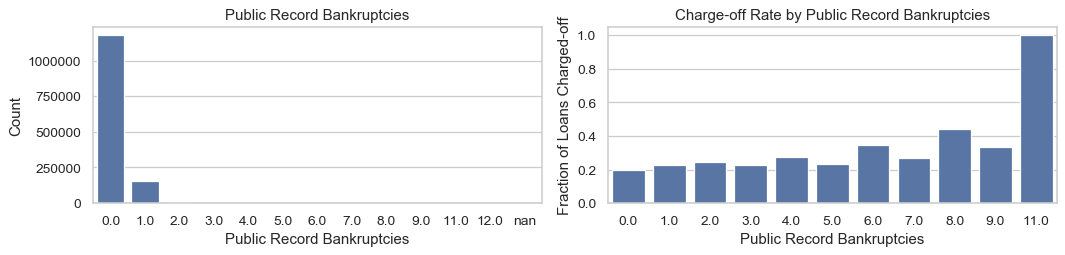

In [122]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# 6. More Pre-processing
<a id="6"></a>

## 6.1 Convert loan status to 0/1 charge-off indicator
<a id="6.1"></a>

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [123]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

## 6.2 Create dummy variables
<a id="6.2"></a>

How many variables do we currently have?

In [124]:
loans.shape

(1345310, 25)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [125]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [126]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

emp_length             0.058
mort_acc               0.035
revol_util             0.001
pub_rec_bankruptcies   0.001
dti                    0.000
dtype: float64


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [127]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [128]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [129]:
loans.shape

(1345310, 122)

Check our data with the new dummy variables:

In [130]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
1266159,9125.000,36,14.990,316.280,1.000,Jun-2014,27.440,2003,31.000,0.000,75.000,51.000,0.000,0.000,4.477,662.000,4.098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2123681,10000.000,36,20.000,371.640,0.000,Oct-2017,21.060,2006,9.000,0.000,65.400,41.000,1.000,0.000,4.740,677.000,3.930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
668006,16000.000,60,13.990,372.210,10.000,Jun-2016,14.200,2002,7.000,1.000,56.700,28.000,3.000,1.000,4.732,662.000,4.138,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
788992,13000.000,36,11.550,429.000,10.000,Aug-2018,15.890,2001,9.000,0.000,66.100,14.000,0.000,0.000,4.881,712.000,4.466,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
371802,15000.000,60,16.990,372.710,8.000,Feb-2015,21.790,2000,9.000,1.000,59.600,27.000,1.000,1.000,4.653,687.000,3.355,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## 6.3 Train/test split
<a id="6.3"></a>

We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.

In [131]:
loans['issue_d'].sample(5)

639123     Jul-2017
1280709    May-2014
1186168    Oct-2014
116620     Oct-2015
1168530    Oct-2014
Name: issue_d, dtype: object

Are there any missing values?

In [132]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [133]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [134]:
loans['issue_d'].sample(5)

1906891   2012-09-01
1730768   2017-01-01
1708216   2017-02-01
1090871   2016-01-01
88068     2015-11-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [135]:
loans['issue_d'].describe()

count                 1345310
unique                    139
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

There are only 139 unique issue dates over the 11-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in December 2018. The busiest month was March 2016 with 48,937 loans funded in that month. What is the distribution of loans funded in each year?

Text(0.5, 1.0, 'Loans Funded per Year')

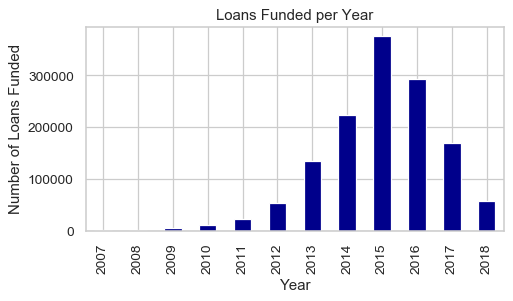

In [136]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [137]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [138]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    1345310
Number of loans in the full dataset: 1345310


What is the test size?

In [139]:
loans_test.shape[0] / loans.shape[0]

0.11111639696426846

About 11.11%. The partition looks good, so we can delete the original `loans` dataframe:

In [140]:
del loans

Let's look at the summary statistics of the issue dates in the train and test sets:

In [141]:
loans_train['issue_d'].describe()

count                 1195824
unique                    120
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2017-05-01 00:00:00
Name: issue_d, dtype: object

In [142]:
loans_test['issue_d'].describe()

count                  149486
unique                     19
top       2017-08-01 00:00:00
freq                    15488
first     2017-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from June 2007 to May 2017. The test set includes loans from July 2016 to December 2018.

Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

In [143]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:

In [144]:
y_train = loans_train['charged_off']
y_test = loans_test['charged_off']

In [145]:
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [146]:
del loans_train, loans_test

# 7. Linear Dependence of Charge-off on the Predictors
<a id="7"></a>

On the training set, we compute the Pearson correlation, $F$-statistic, and $p$ value of each predictor with the response variable `charged_off`.

In [147]:
linear_dep = pd.DataFrame()

Pearson correlations:

In [148]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

$F$-statistics:

In [149]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [150]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [151]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [152]:
linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,int_rate,0.261,87219.489,0.000
1,term,0.182,41137.035,0.000
2,fico_score,-0.131,21007.091,0.000
3,dti,0.101,12261.190,0.000
4,mort_acc,-0.072,6054.501,0.000
5,sub_grade_A4,-0.066,5176.670,0.000
6,log_annual_inc,-0.065,5124.653,0.000
7,sub_grade_A5,-0.065,5105.864,0.000
8,sub_grade_A2,-0.063,4773.118,0.000
9,home_ownership_RENT,0.062,4677.205,0.000


The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [153]:
linear_dep.tail(20)

,variable,pearson_corr,F,p_value
100,addr_state_WY,-0.003,14.512,0.000
101,addr_state_KY,0.003,12.900,0.000
102,addr_state_RI,-0.003,12.525,0.000
103,addr_state_NC,0.003,12.462,0.000
104,addr_state_NM,0.002,7.211,0.007
105,purpose_renewable_energy,0.002,5.298,0.021
106,addr_state_TX,-0.002,3.854,0.050
107,addr_state_SD,0.002,3.103,0.078
108,addr_state_MI,0.001,1.866,0.172
109,purpose_vacation,-0.001,1.737,0.188


It looks like the borrower's state of residence, the revolving balance, and several of the loan purposes are irrelevant for predicting charge-off.

# 8. Model Training and Testing
<a id="8"></a>

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Random forest
3. k-nearest neighbors

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

## 8.1 Logistic regression with SGD training
<a id="8.1"></a>

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

In [159]:
from sklearn.linear_model import SGDClassifier

The machine learning pipeline:

In [160]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [161]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [162]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [163]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=False,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=False,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False

Mean cross-validated AUROC score of the best model:

In [164]:
grid_sgdlogreg.best_score_

0.7114120054770521

Best hyperparameters:

In [165]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

## 8.2 Random forest classifier
<a id="8.2"></a>

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [166]:
from sklearn.ensemble import RandomForestClassifier

In [168]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [169]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

In [170]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [171]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=False,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=No

Mean cross-validated AUROC score of the random forest:

In [172]:
grid_rfc.best_score_

0.6943352951183979

Not quite as good as logistic regression, at least according to this metric.

## 8.3 k-nearest neighbors
<a id="8.3"></a>

Next we try k-nearest neighbors. We need to reduce the number of variables to 10 or fewer ([reference](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)) for kNN to perform well. We'll use LDA for dimension reduction. The number of component variables to keep is a hyperparameter.

In [173]:
from sklearn.neighbors import KNeighborsClassifier

In [174]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

In [175]:
param_grid_knn = {
    'lda__n_components': [3, 9], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

In [176]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [177]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=False,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=False,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lda',
                                        LinearDiscriminantAnalysis(n_components=None,
                                                   

Mean cross-validated AUROC score of the best model:

In [178]:
grid_knn.best_score_

0.7029806543196433

Best hyperparameters:

In [179]:
grid_knn.best_params_

{'lda__n_components': 3, 'model__n_neighbors': 125}

Only 3 LDA components are necessary for kNN to perform almost as well as logistic regression.

## 8.4 Tune hyperparameters on the chosen model more finely
<a id="8.4"></a>

The three models performed quite similarly according to the AUROC:

In [180]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')
print(grid_knn.best_score_, '- k-nearest neighbors')

Cross-validated AUROC scores
0.7114120054770521 - Logistic regression
0.6943352951183979 - Random forest
0.7029806543196433 - k-nearest neighbors


Logistic regression squeaked out ahead, and coupled with the fact that `SGDClassifier` trains much faster than the other two models, we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [181]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

print(param_grid_sgdlogreg)

{'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]), 'model__penalty': ['l1', 'l2']}


In [182]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [183]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 25.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=False,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=False,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False

Mean cross-validated AUROC score of the best model:

In [184]:
grid_sgdlogreg.best_score_

0.7114120054770521

Best hyperparameters:

In [185]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

By some coincidence, the optimal hyperparameters here are the same as those from our first grid search for logistic regression!

## 8.5 Test set evaluation
<a id="8.5"></a>

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [186]:
from sklearn.metrics import roc_auc_score

In [187]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.7037841678710398

The test set AUROC score is somewhat lower than the cross-validated score (0.711).

# 9. Conclusion
<a id="9"></a>

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating three different models (logistic regression, random forest, and k-nearest neighbors), we found that all three performed similarly according to a cross-validated AUROC score on the training data. We selected logistic regression (with ridge penalty) because it was the fastest model to train, and this model obtained an AUROC score of 0.703 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

We also found that, according to the Pearson correlations between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.